In [7]:
!pip install -q wfdb
!pip install -q neurokit2
!pip install -q biosppy

# # Download Full Dataset
# # !wget -q -r -N -c -np https://physionet.org/files/edb/1.0.0/ 

In [8]:
import numpy as np
import wfdb
import neurokit2 as nk
import matplotlib.pyplot as plt
import os
import pandas as pd
import biosppy.signals.ecg as ecg
import random


In [9]:
record_nums = [103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 118, 119, 121, 122, 123, 124, 125, 126, 127, 129, 133, 136, 139, 147, 148, 151, 154, 155, 159, 161, 162, 163, 166, 170, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 302, 303, 304, 305, 306, 403, 404, 405, 406, 408, 409, 410, 411, 413, 415, 417, 418, 501, 509, 515, 601, 602, 603, 604, 605, 606, 607, 609, 610, 611, 612, 613, 614, 615, 704, 801, 808, 817, 818, 1301, 1302, 1304]
record_dir = '/Users/ghanem/Desktop/ECG-ST-Detection/edb'

In [10]:
def download_record(i):
  record_name = ('e0' + str(i)) if i < 1000 else 'e' + str(i)
  file_list = [record_name + '.dat', record_name + '.hea', record_name + '.atr']
  # file_list = [record_name + '.dat', record_name + '.hea', record_name + '.atr', record_name + '.sta', record_name + '.stb', record_name + '.stc']
  if all(os.path.isfile(os.path.join(record_dir, f)) for f in file_list):
    print(f"{record_name} files already exist.")
    return
  
  wfdb.dl_files('edb', os.getcwd() + '/edb', files=file_list, overwrite=True)
  print(f"{record_name} files downloaded.")

In [11]:
for i in record_nums:
  download_record(i)

e0103 files already exist.
e0104 files already exist.
e0105 files already exist.
e0106 files already exist.
e0107 files already exist.
e0108 files already exist.
e0110 files already exist.
e0111 files already exist.
e0112 files already exist.
e0113 files already exist.
e0114 files already exist.
e0115 files already exist.
e0116 files already exist.
e0118 files already exist.
e0119 files already exist.
e0121 files already exist.
e0122 files already exist.
e0123 files already exist.
e0124 files already exist.
e0125 files already exist.
e0126 files already exist.
e0127 files already exist.
e0129 files already exist.
e0133 files already exist.
e0136 files already exist.
e0139 files already exist.
e0147 files already exist.
e0148 files already exist.
e0151 files already exist.
e0154 files already exist.
e0155 files already exist.
e0159 files already exist.
e0161 files already exist.
e0162 files already exist.
e0163 files already exist.
e0166 files already exist.
e0170 files already exist.
e

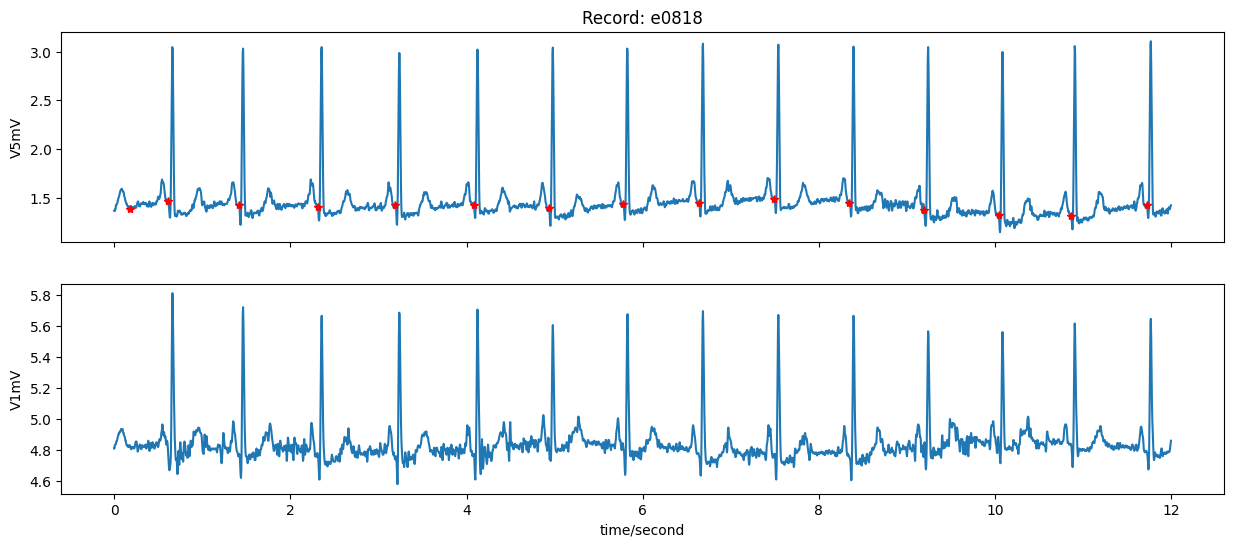

In [19]:
record_name = 'e0818'
record_name = 'edb/' + record_name
record = wfdb.rdrecord(record_name, sampto=3000)
annotation = wfdb.rdann(record_name, 'atr', sampto=3000)
wfdb.plot_wfdb(record=record, annotation=annotation, time_units='seconds', figsize=(15,6))

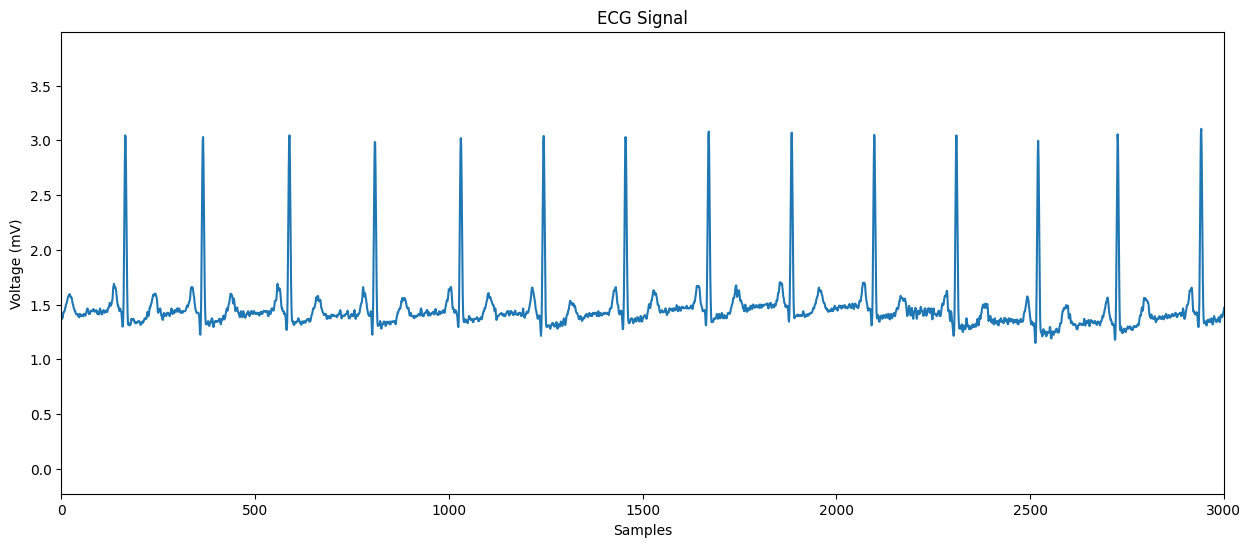

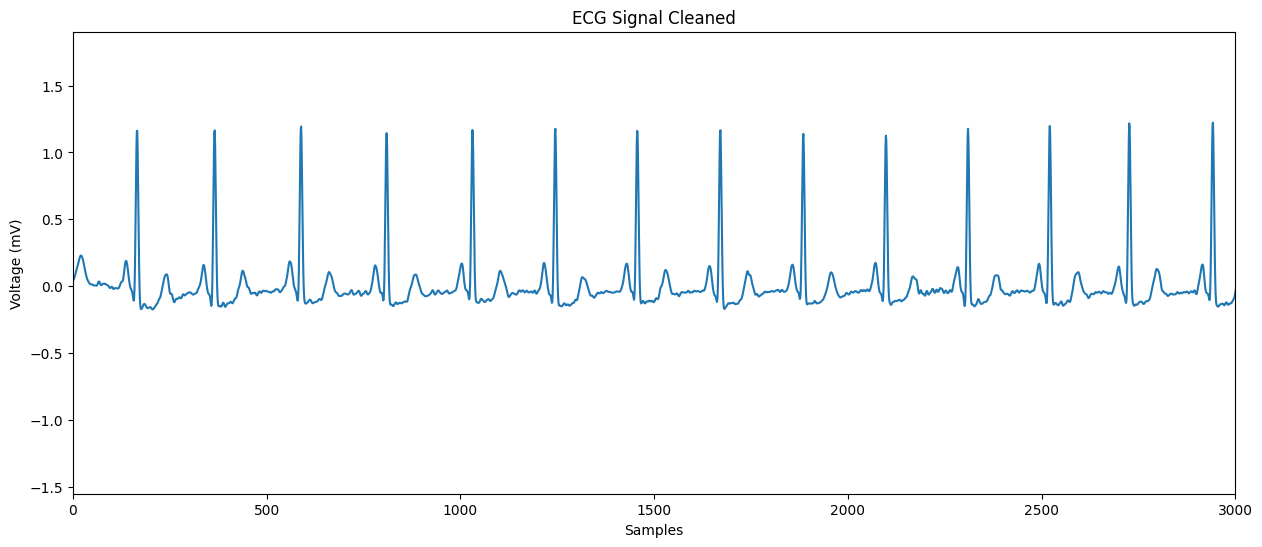

In [20]:
signal, fields = wfdb.rdsamp(record_name, channels=[0])
fs = fields['fs']
signal = np.array(signal).flatten()
signal_clean = nk.ecg_clean(signal, sampling_rate=fs)

plt.figure(figsize=(15, 6))
plt.plot(signal)
plt.xlabel('Samples')
plt.ylabel('Voltage (mV)')
plt.title('ECG Signal')
plt.xlim( 0 , 3000)
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(signal_clean)
plt.xlabel('Samples')
plt.ylabel('Voltage (mV)')
plt.title('ECG Signal Cleaned')
plt.xlim( 0 , 3000)
plt.show()

In [21]:
def match_parentheses(input_list, input_idx):
    stack = []
    result = []

    for i, item in enumerate(input_list):
        if '(ST' in item:
            stack.append((item, i))
        elif ')' in item:
            if not stack:
                print(f"Error: Unmatched closing parenthesis at index {i}")
                continue
            _, open_idx = stack.pop()
            result.append((input_idx[open_idx], input_idx[i]))

    if stack:
        print("Error: Unmatched opening parentheses")
    
    return result

In [22]:
annotation = wfdb.rdann('e1302', extension='atr', pn_dir='edb', summarize_labels=True)

ann_symbol = np.array(annotation.symbol)
ann_sample = np.array(annotation.sample)
aux_note = np.array(annotation.aux_note)
mask = ann_symbol == 's'
st_annotations_idx = ann_sample[mask]
st_annotations = aux_note[mask]

print(st_annotations_idx)
print(st_annotations)

matches = match_parentheses(st_annotations, st_annotations_idx)
print(matches)

[174342 191548 206447 206843 210950 223764 612781 632995 633721 637528
 645374 689731]
['(ST1-' '(ST0+' 'AST1-100' 'AST0+200' 'ST0+)' 'ST1-)' '(ST1-' 'AST1-100'
 '(ST0+' 'AST0+100' 'ST0+)' 'ST1-)']
[(191548, 210950), (174342, 223764), (633721, 645374), (612781, 689731)]


/Users/ghanem/miniconda3/lib/python3.11/site-packages/wfdb/io/annotation.py:1357: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  contained_labels = label_map.loc[index_vals, :]


In [23]:
features, _ = nk.ecg_process(signal_clean, sampling_rate=fs)

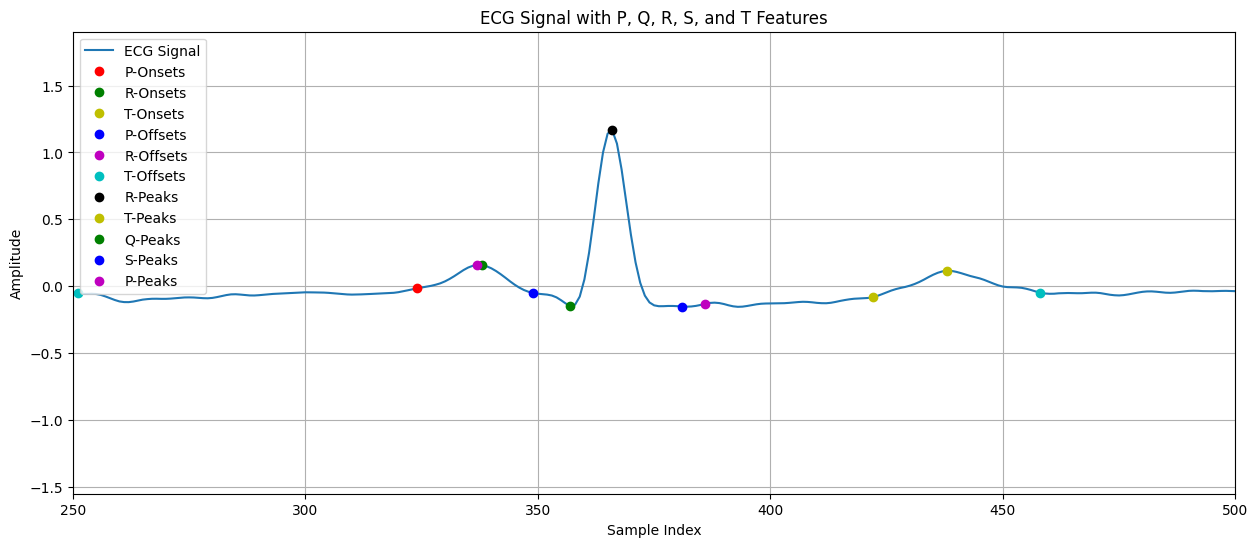

In [25]:
p_onsets = features["ECG_P_Onsets"]
r_onsets = features["ECG_R_Onsets"]
t_onsets = features["ECG_T_Onsets"]
p_offsets = features["ECG_P_Offsets"]
r_offsets = features["ECG_R_Offsets"]
t_offsets = features["ECG_T_Offsets"]
r_peaks = features["ECG_R_Peaks"]
t_peaks = features["ECG_T_Peaks"]
q_peaks = features["ECG_Q_Peaks"]
s_peaks = features["ECG_S_Peaks"]
p_peaks = features["ECG_P_Peaks"]
heart_rate = features["ECG_Rate"]

# signal_clean = signal_clean[:100000]
plt.figure(figsize=(15, 6))
plt.plot(signal_clean, label="ECG Signal")
samples = np.arange(len(signal_clean))

p_onsets_mask = p_onsets == 1
p_onsets_idx = samples[p_onsets_mask]
plt.plot(samples[p_onsets_mask], signal_clean[p_onsets_mask], 'ro', label="P-Onsets")

r_onsets_mask = r_onsets == 1
r_onsets_idx = samples[r_onsets_mask]
plt.plot(samples[r_onsets_mask], signal_clean[r_onsets_mask], 'go', label="R-Onsets")

t_onsets_mask = t_onsets == 1
t_onsets_idx = samples[t_onsets_mask]
plt.plot(samples[t_onsets_mask], signal_clean[t_onsets_mask], 'yo', label="T-Onsets")

p_offsets_mask = p_offsets == 1
p_offsets_idx = samples[p_offsets_mask]
plt.plot(samples[p_offsets_mask], signal_clean[p_offsets_mask], 'bo', label="P-Offsets")

r_offsets_mask = r_offsets == 1
r_offsets_idx = samples[r_offsets_mask]
plt.plot(samples[r_offsets_mask], signal_clean[r_offsets_mask], 'mo', label="R-Offsets")

t_offsets_mask = t_offsets == 1
t_offsets_idx = samples[t_offsets_mask]
plt.plot(samples[t_offsets_mask], signal_clean[t_offsets_mask], 'co', label="T-Offsets")

r_peaks_mask = r_peaks == 1
r_peaks_idx = samples[r_peaks_mask]
plt.plot(samples[r_peaks_mask], signal_clean[r_peaks_mask], 'ko', label="R-Peaks")

t_peaks_mask = t_peaks == 1
t_peaks_idx = samples[t_peaks_mask]
plt.plot(samples[t_peaks_mask], signal_clean[t_peaks_mask], 'yo', label="T-Peaks")

q_peaks_mask = q_peaks == 1
q_peaks_idx = samples[q_peaks_mask]
plt.plot(samples[q_peaks_mask], signal_clean[q_peaks_mask], 'go', label="Q-Peaks")

s_peaks_mask = s_peaks == 1
s_peaks_idx = samples[s_peaks_mask]
plt.plot(samples[s_peaks_mask], signal_clean[s_peaks_mask], 'bo', label="S-Peaks")

p_peaks_mask = p_peaks == 1
p_peaks_idx = samples[p_peaks_mask]
plt.plot(samples[p_peaks_mask], signal_clean[p_peaks_mask], 'mo', label="P-Peaks")

plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.title("ECG Signal with P, Q, R, S, and T Features")
plt.grid()

plt.xlim(250, 500)
plt.show()

In [26]:
beats = nk.ecg_segment(signal_clean, sampling_rate=fs)

In [33]:
def r_wave_amplitude(r_peak_loc):
    if len(r_peak_loc) >= 1:
        r_amplitude = float(r_peak_loc.values[0])
        return r_amplitude
    return np.nan

def r_wave_duration(q_peak_loc, t_onset_loc):
    if len(q_peak_loc) >= 1 and len(t_onset_loc) >= 1:
        r_duration = float(q_peak_loc.index[0] - t_onset_loc.index[0])
        return r_duration
    return np.nan

def t_wave_amplitude(t_peak_loc):
    if len(t_peak_loc) >= 1:
        t_amplitude = float(t_peak_loc.values[0])
        return t_amplitude
    return np.nan

def t_wave_duration(t_offset_loc, t_onset_loc):
    if len(t_offset_loc) >= 1 and len(t_onset_loc) >= 1:
        t_duration = float(t_offset_loc.index[0] - t_onset_loc.index[0])
        return t_duration
    return np.nan

def s_wave_amplitude(s_peak_loc):
    if len(s_peak_loc) >= 1:
        s_amplitude = float(s_peak_loc.values[0])
        return s_amplitude
    return np.nan

def qt_interval(t_offset_loc, p_offset_loc):
    if len(t_offset_loc) >= 1 and len(p_offset_loc) >= 1:
        qt_interval = float(t_offset_loc.index[0] - p_offset_loc.index[0])
        return qt_interval
    return np.nan

def heart_rate_calc(hr, idx):
    if idx > 0:
        return float(hr[idx])
    return np.nan


def j_point_calc(s_peak_loc, t_peak_loc, x, y):
    if len(s_peak_loc) == 0 or len(t_peak_loc) == 0:
        return np.nan, np.nan, None
    if s_peak_loc.index[0] > t_peak_loc.index[0]:
        return np.nan, np.nan, None
    s_peak_ind = int(np.interp(s_peak_loc.index[0], x, np.arange(len(x))))
    t_peak_ind = int(np.interp(t_peak_loc.index[0], x, np.arange(len(x))))
    y_st_by_peaks = y[s_peak_ind:t_peak_ind+1]
    x_st_by_peaks = x[s_peak_ind:t_peak_ind+1]
    if t_peak_ind - s_peak_ind < 1:
        return np.nan, np.nan, None
    Fy = np.gradient(y_st_by_peaks)
    j_point_pseudo_ind = np.abs(Fy).argmin()
    j_point = [x_st_by_peaks[j_point_pseudo_ind], y_st_by_peaks[j_point_pseudo_ind]]
    j_point_ind = int(np.round(np.interp(x_st_by_peaks[j_point_pseudo_ind], x, np.arange(len(x)))))
    j_magnitude = j_point[1]

    return j_point, j_magnitude, j_point_ind

def st_duration_calc(t_peak_loc, j_point):
    if len(t_peak_loc) >= 1 and isinstance(j_point, list) and len(j_point) == 2:
        st_duration = t_peak_loc.index[0] - j_point[0]
        return st_duration
    return np.nan

def st_slope_calc(t_onset_loc, j_point_ind, x, y):
    if len(t_onset_loc) >= 1 and j_point_ind is not None:
        t_onset_ind = int(np.round(np.interp(t_onset_loc.index[0], x, np.arange(len(x)))))

        if t_onset_ind > j_point_ind:
            y_st_slope_range = y[j_point_ind:t_onset_ind+1]
            x_st_slope_range = x[j_point_ind:t_onset_ind+1]

            F_st_slope = np.gradient(y_st_slope_range)
            st_slope = np.mean(F_st_slope)
            st_slope_bool = st_slope > 0
            return st_slope
    return np.nan

def st_area_calc(t_offset_loc, j_point_ind, x, y,):
    if len(t_offset_loc) >= 1 and j_point_ind is not None:
        ind_t_offset = int(np.round(np.interp(t_offset_loc.index[0], x, np.arange(len(x)))))
        y_st_area_range = y[j_point_ind:ind_t_offset+1]
        x_st_area_range = x[j_point_ind:ind_t_offset+1]
        st_area = np.trapz(y_st_area_range, x_st_area_range)
        return st_area
    return np.nan


In [36]:
def extract_features(beats, features, ranges, gender):
    
    p_onsets = features["ECG_P_Onsets"]
    r_onsets = features["ECG_R_Onsets"]
    t_onsets = features["ECG_T_Onsets"]
    p_offsets = features["ECG_P_Offsets"]
    r_offsets = features["ECG_R_Offsets"]
    t_offsets = features["ECG_T_Offsets"]
    r_peaks = features["ECG_R_Peaks"]
    t_peaks = features["ECG_T_Peaks"]
    q_peaks = features["ECG_Q_Peaks"]
    s_peaks = features["ECG_S_Peaks"]
    p_peaks = features["ECG_P_Peaks"]
    heart_rate = features["ECG_Rate"]

    record_dataset = pd.DataFrame(columns=['R_wave_amplitude', 'R_wave_duration', 'T_wave_amplitude', 'T_wave_duration', 'S_wave_amplitude', 'QT_interval', 'Heart_rate','J_point_amplitude', 'ST_duration', 'ST_area', 'ST_slope', 'Gender', 'Label'])
    
    for i in range(1, len(beats)+1):
        # print("Beat Number:", i)
        beat = beats[str(i)]
        beat_signal = beat['Signal']
        time = beat_signal.index
        voltage = beat_signal.values
        beat_idx = beat['Index'].values
        min_idx, max_idx = beat_idx[0], beat_idx[-1]

        s_peak_loc = beat_signal.iloc[np.argwhere(s_peaks[min_idx:max_idx].values == 1).flatten()]
        r_onset_loc = beat_signal.iloc[np.argwhere(r_onsets[min_idx:max_idx].values == 1).flatten()]
        t_onset_loc = beat_signal.iloc[np.argwhere(t_onsets[min_idx:max_idx].values == 1).flatten()]
        p_offset_loc = beat_signal.iloc[np.argwhere(p_offsets[min_idx:max_idx].values == 1).flatten()]
        r_offset_loc = beat_signal.iloc[np.argwhere(r_offsets[min_idx:max_idx].values == 1).flatten()]
        t_offset_loc = beat_signal.iloc[np.argwhere(t_offsets[min_idx:max_idx].values == 1).flatten()]
        r_peak_loc = beat_signal.iloc[np.argwhere(r_peaks[min_idx:max_idx].values == 1).flatten()]
        t_peak_loc = beat_signal.iloc[np.argwhere(t_peaks[min_idx:max_idx].values == 1).flatten()]
        q_peak_loc = beat_signal.iloc[np.argwhere(q_peaks[min_idx:max_idx].values == 1).flatten()]
        label = 0

        for start, end in ranges:
            if start <= min_idx and end >= max_idx:
                label = 1
                break
        
        r_amplitude = r_wave_amplitude(r_peak_loc)
        r_duration = r_wave_duration(q_peak_loc, r_onset_loc)
        t_amplitude = t_wave_amplitude(t_peak_loc)
        t_duration = t_wave_duration(t_offset_loc, t_onset_loc)
        s_amplitude = s_wave_amplitude(s_peak_loc)
        qt_int = qt_interval(t_offset_loc, p_offset_loc)
        hr = heart_rate_calc(heart_rate, (min_idx + max_idx) // 2)
        j_point, j_magnitude, j_point_ind = j_point_calc(s_peak_loc, t_peak_loc, time, voltage)
        st_duration = st_duration_calc(t_peak_loc, j_point)
        st_slope = st_slope_calc(t_onset_loc, j_point_ind, time, voltage)
        st_area = st_area_calc(t_offset_loc, j_point_ind, time, voltage)


        feature_row = {
            'R_wave_amplitude': r_amplitude,
            'R_wave_duration': r_duration,
            'T_wave_amplitude': t_amplitude,
            'T_wave_duration': t_duration,
            'S_wave_amplitude': s_amplitude,
            'QT_interval': qt_int,
            'Heart_rate': hr,
            'J_point_amplitude': j_magnitude,
            'ST_duration': st_duration,
            'ST_area': st_area,
            'ST_slope': st_slope,
            'Gender': gender,
            'Label': label
        }

        p = random.random()
        feature_row = pd.DataFrame([feature_row])

        if feature_row.isna().any().any():
            continue
        elif label == 1:
            record_dataset = pd.concat([record_dataset, feature_row], ignore_index=True)
        elif p < 0.5:
            record_dataset = pd.concat([record_dataset, feature_row], ignore_index=True)

    return record_dataset

In [37]:
random.shuffle(record_nums)
split_point = int(len(record_nums) * 0.7)
train_record_nums = record_nums[:split_point]
test_record_nums = record_nums[split_point:]

In [38]:
def create_dataset(records):
    dataset = pd.DataFrame(columns=['R_wave_amplitude', 'R_wave_duration', 'T_wave_amplitude', 'T_wave_duration', 'S_wave_amplitude', 'QT_interval', 'Heart_rate','J_point_amplitude', 'ST_duration', 'ST_area', 'ST_slope', 'Gender', 'Label'])
    for i in records:

        # Signal Information Extraction
        record_name = 'e0' + str(i) if i < 1000 else 'e' + str(i)
        record_name = 'edb/' + record_name
        signal, fields = wfdb.rdsamp(record_name, channels=[0])
        gender = 1 if 'Sex: F' in fields['comments'][0] else 0
        signal = np.array(signal).flatten()
        fs = fields['fs']

        # Signal Cleaning
        signal_clean = nk.ecg_clean(signal, sampling_rate=fs)

        # Annotation Extraction
        annotation = wfdb.rdann(record_name, 'atr')
        ann_symbol = np.array(annotation.symbol)
        ann_sample = np.array(annotation.sample)
        aux_note = np.array(annotation.aux_note)
        st_annotations_idx = ann_sample[ann_symbol == 's']
        st_annotations = aux_note[ann_symbol == 's']
        ranges = match_parentheses(st_annotations, st_annotations_idx)

        # Low-level Feature Extraction
        features, _ = nk.ecg_process(signal_clean, sampling_rate=fs)

        # Beat Segmentation
        beats = nk.ecg_segment(signal_clean, sampling_rate=fs)

        # Dataset Extraction and Concatenation
        record_dataset = extract_features(beats, features, ranges, gender)
        dataset = pd.concat([dataset, record_dataset], axis=0)
        
    return dataset

In [39]:
train_dataset = create_dataset(train_record_nums)
test_dataset = create_dataset(test_record_nums)
train_dataset.to_csv('train_data.csv', index=False)
test_dataset.to_csv('test_data.csv', index=False)

/Users/ghanem/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ghanem/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ghanem/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ghanem/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ghanem/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ghanem/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encounte

Error: Unmatched opening parentheses
Error: Unmatched opening parentheses
Error: Unmatched opening parentheses
